<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

In [386]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

np.printoptions(precision=4)

#Some plot settings
%run plot_functions/plot_settings.py

# HM coupling in 1D -- liquefaction test

## Strong form

\begin{align}
    0 &= \partial_z \sigma_{zz} + \gamma_\text{r} = \partial_z (\sigma_{zz}' - p) + \gamma_\text{r} = \partial_z \left[ E_\text{s} \partial_z u_z \right] - \partial_z p + \gamma_\text{r}\\
    0 &= n\beta_p \dot{p} + \partial_z (\dot{u}_z + q_z) = n\beta_p \dot{p} + \partial_z \dot{u}_z - \partial_z \left[ \frac{k}{\mu} \left( \partial_z p - \gamma_\text{w} \right) \right]
\end{align}

## Weak form

The displacements can have (the essential/Dirichlet) boundary conditions in the form:

$$
    u = \bar{u}\ \forall z \in \partial \Omega_\mathrm{D}% \qquad \text{and} \qquad - E_\text{s}A \frac{\partial u_z}{\partial z} = \bar{F} \ \forall z \in \partial \Omega_\mathrm{N}
$$

We now introduce a test function $\delta u$ (virtual displacement) which vanishes where the displacement is given

$$
    \delta u = 0\ \forall z \in \partial \Omega_\mathrm{D}
$$

and construct the weak form of the equilibrium conditions (using integration by parts):

\begin{align}
   0 &= \int \limits_0^H \left[\partial_z \sigma_{zz} + \gamma_\text{r} \right] \delta u\, \text{d}z
   \\
   &= \int \limits_0^H \left[\frac{\partial}{\partial z} \left(\sigma_{zz} \delta u \right) - \partial_z \delta u \ \sigma_{zz} + \gamma_\text{r} \delta u \right] \, \text{d}z
\end{align}

Integrating the first term yields the natural/Neumann boundary conditions, so that
$$
\left[ \sigma_{zz} \delta u \right]_0^H + \int \limits_0^H \gamma_\text{r} \delta u \text{d}z = \int \limits_0^H \partial_z \delta u\ (\sigma_{zz}' - p)  \, \text{d}z
$$
which is recognised as the principal of virtual work: $\delta W_\text{ext} = \delta W_\text{int}$.

The pore pressure can have (the essential/Dirichlet) boundary conditions in the form:

$$
    p = \bar{p}\ \forall z \in \partial \Omega_\mathrm{D}% \qquad \text{and} \qquad - E_\text{s}A \frac{\partial u_z}{\partial z} = \bar{F} \ \forall z \in \partial \Omega_\mathrm{N}
$$

We now introduce a test function $\delta p$ which vanishes where the pressure is given

$$
    \delta p = 0\ \forall z \in \partial \Omega_\mathrm{D}
$$

and construct the weak form of the equilibrium conditions (using integration by parts):

\begin{align}
   0 &= \int \limits_0^H \left[n\beta_p \dot{p} + \partial_z (\dot{u}_z + q_z) \right] \delta p\, \text{d}z
   \\
   &= \int \limits_0^H \left[ \partial_z (\delta p\, q_z) - q_z \partial_z \delta p + \partial_z \dot{u}_z \delta p + n\beta_p \dot{p} \delta p \right] \, \text{d}z
\end{align}

Integrating the first term yields the natural/Neumann boundary conditions, so that
$$
\left[ q_z \delta p \right]_0^H = \int \limits_0^H \left[ \partial_z \delta p\ q_z - n\beta_p \dot{p} \delta p - \delta p\, \partial_z \dot{u}_z \right] \, \text{d}z
$$

## Finite elements in 1D

We first create an element class. An element knows the number of nodes it has, their IDs in the global node vector, and the coordinates of its nodes. Linear elements have 2 nodes and 2 quadrature points, quadratic elements 3 nodes and 3 quadrature points. The natural coordinates of the element run from -1 to 1, and the quadrature points and weights are directly taken from Numpy.

In [387]:
#element class
class line_element():#local coordinates go from -1 to 1
    #takes number of nodes, global nodal coordinates, global node ids
    def __init__(self, nnodes=2, ncoords=[0.,1.], nids=[0,1]):
        self.__nnodes = nnodes
        if (len(ncoords) != self.__nnodes):
            raise Exception("Number of coordinates does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(ncoords)))
        else:
            self.__coords = np.array(ncoords)
        
        self.__natural_coords = (self.__coords-self.__coords[0])/(self.__coords[-1]-self.__coords[0])*2. - 1.
        
        if (len(nids) != self.__nnodes):
            raise Exception("Number of node IDs does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(nids)))
        else:
            self.__global_ids = np.array(nids)
        self.__quad_degree = self.__nnodes
        self.__quad_points, self.__quad_weights = np.polynomial.legendre.leggauss(self.__quad_degree)
                

Next, we wish to generate a one-dimensional mesh by specifying the length of a line, the number of elements into which the mesh is to be split, and the number of nodes per element.

In [388]:
def number_of_nodes(nelems,nodes_per_elem):
    return nelems*nodes_per_elem - (nelems - 1)

def generate_node_ids_u(num_iterations):
    sequence = []
    last_element = 0

    for i in range(num_iterations):
        if i == 0:
            triplet = (0, 1, 2)
        elif i == 1:
            triplet = (2, 5, 6)
        else:
            a = last_element
            b = a + 2
            c = b + 1
            triplet = (a, b, c)
        
        sequence.append(triplet)
        last_element = triplet[-1]
    return sequence

def generate_node_ids_p(num_iterations):
    sequence = []
    last_element = 3  # Start with the first element as 3

    for i in range(num_iterations):
        if i == 0:
            pair = (3, 4)
        else:
            a = last_element
            b = a + 3
            pair = (a, b)
        
        sequence.append(pair)
        last_element = pair[-1]
    return sequence

def generate_mesh(domain_length,nelems,nodes_per_elem):
    nn = number_of_nodes(nelems,nodes_per_elem)
    #coordinate vector of global nodes
    global_nodal_coordinates = np.linspace(0.,domain_length,nn)
    global_solution = np.array([0.]*nn)
    
    #generate elements
    element_vector = []
    if (nodes_per_elem == 3):
        node_ids = generate_node_ids_u(nelems)
    else:
        node_ids = generate_node_ids_p(nelems)
    for i in range(nelems):
        node_start = (nodes_per_elem-1)*i
        node_start_id = (2*nodes_per_elem-2)*i
        element_vector.append(
            line_element(nodes_per_elem,
                         global_nodal_coordinates[node_start:node_start+nodes_per_elem],
                         node_ids[i]))
        
    return global_nodal_coordinates, element_vector, global_solution

Let's put this to test.

In [389]:
number_of_elements = 20
L = 10.
nodes_per_element = 3

nodes_u,elements_u,solution_u=generate_mesh(L,number_of_elements,nodes_per_element)
nodes_p,elements_p,solution_p=generate_mesh(L,number_of_elements,nodes_per_element-1)
solution = np.append(solution_u,solution_p)

In [390]:
def split_sol(n_els, solution):
    sol_u = np.array([])
    sol_p = np.array([])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(n_els) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(n_els) for item in sublist])
    return solution[n_ids_u], solution[n_ids_p]

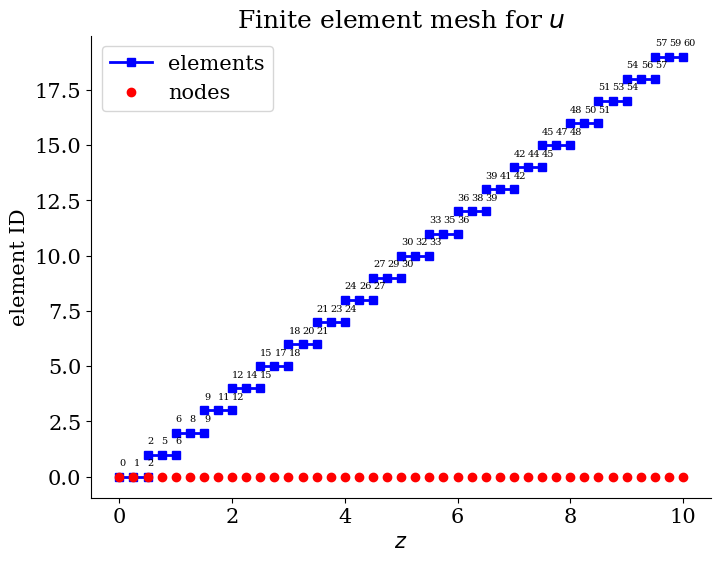

In [391]:
plt.xlabel('$z$')
plt.ylabel('element ID')
plt.title('Finite element mesh for $u$')
for i,elem in enumerate(elements_u):
    if (i==0):
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-', label='elements')
    else:
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-')
    for k in range(elem._line_element__nnodes):
        plt.text(elem._line_element__coords[k],i+0.5,str(elem._line_element__global_ids[k]),size=7)
plt.plot(nodes_u, [0]*len(nodes_u), 'ro ', label='nodes')
plt.legend();

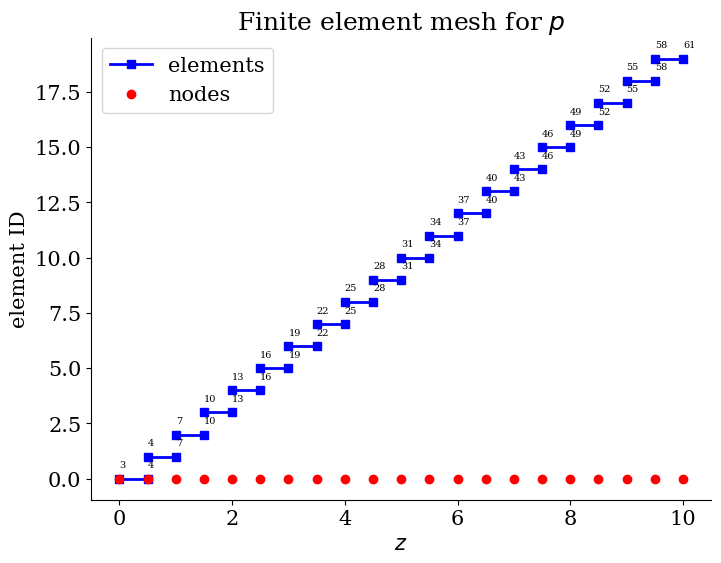

In [392]:
plt.xlabel('$z$')
plt.ylabel('element ID')
plt.title('Finite element mesh for $p$')
for i,elem in enumerate(elements_p):
    if (i==0):
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-', label='elements')
    else:
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-')
    for k in range(elem._line_element__nnodes):
        plt.text(elem._line_element__coords[k],i+0.5,str(elem._line_element__global_ids[k]),size=7)
plt.plot(nodes_p, [0]*len(nodes_p), 'ro ', label='nodes')
plt.legend();

In [393]:
#N
def shape_function(element_order,xi):
    if (element_order == 2): #-1,1
            return np.array([(1.-xi)/2., (1.+xi)/2.])
    elif (element_order == 3): #-1, 0, 1
            return np.array([(xi - 1.)*xi/2., (1-xi)*(1+xi), (1+xi)*xi/2.])
#dN_dxi
def dshape_function_dxi(element_order,xi):
    if (element_order == 2): #-1,1
        return np.array([-0.5, 0.5])  #xi only later for plotting dimensions
    elif (element_order == 3):#-1,0,1
        return np.array([xi - 0.5,-2.*xi,xi + 0.5])

#dz_dxi
def element_jacobian(element,xi):
    element_order = element._line_element__nnodes
    Jacobian = 0.
    Jacobian += dshape_function_dxi(element_order,xi).dot(element._line_element__coords)
    return Jacobian

#dN_dz
def grad_shape_function(element,xi):
    element_order = element._line_element__nnodes
    Jac = element_jacobian(element,xi)
    return dshape_function_dxi(element_order,xi)/Jac


## Discretization of virtual work (weak form)

The discretized system is given as

\begin{align}
    {\sigma}_{zz}(z=H)\delta_{in_\text{n}} - {\sigma}_{zz}(z=0) \delta_{i0} + \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \gamma_\text{r} N^u_i \det J \, \text{d}\xi &= \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i^u (\sigma_{zz}' - p)\det J  \, \text{d}\xi
    \\
    {q}_{z}(z=H)\delta_{in_\text{n}} - {q}_{z}(z=0) \delta_{i0} &= \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i^p q_z \det J  \, \text{d}\xi - \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} N_i^p \left[ \frac{\partial_z u_z - \partial_z u_z^\text{prev}}{\Delta t} + n\beta_p\frac{p - p^\text{prev}}{\Delta t} \right]\det J  \, \text{d}\xi 
\end{align}

The latter equation was modified to yield a symmetric stiffness matrix:

\begin{align}
    {\sigma}_{zz}(z=H)\delta_{in_\text{n}} - {\sigma}_{zz}(z=0) \delta_{i0} + \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \gamma_\text{r} N^u_i \det J \, \text{d}\xi &= \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i^u (\sigma_{zz}' - p)\det J  \, \text{d}\xi
    \\
    {q}_{z}(z=H)\delta_{in_\text{n}} \Delta t - {q}_{z}(z=0) \delta_{i0} \Delta t &= \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i^p q_z \Delta t\det J  \, \text{d}\xi - \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} N_i^p \left[ \Delta \partial_z u_z + n\beta_p\Delta p  \right]\det J  \, \text{d}\xi 
\end{align}

What we require now is the local assembler to calculate the stiffness matrix and the local right-hand side. Local integration is performed by Gauss quadrature:

$$
    \int \limits_{-1}^1 f(\xi)\,\text{d}\xi \approx \sum \limits_{i=1}^{n_\text{gp}} f(\xi_i) w_i 
$$

## Local assember

In [394]:
def Stiffness(z):
    return 1e8

def gamma_r(z):
    n=0.4
    return -(26000.*(1.-n) + 10000.*n) #kg/m³

def gamma_w():
    return -10000.

def Conductivity(z):
    return 1e-11/1e-3

def Compressibility(z):
    return 5e-10*0.4

In [395]:
def local_assembler_res(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt):
    element_order = elem_u._line_element__nnodes
    res_loc = np.zeros(2*element_order-1)
    z_nodes = elem_u._line_element__coords
    for i in range(elem_u._line_element__quad_degree):
        #local integration point coordinate
        xi = elem_u._line_element__quad_points[i]
        #shape function
        N_u = shape_function(element_order,xi)
        N_p = shape_function(element_order-1,xi)
        #gradient of shape function
        dN_u_dX = grad_shape_function(elem_u,xi)
        dN_p_dX = grad_shape_function(elem_p,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem_u,xi))
        #integration weight
        w = elem_u._line_element__quad_weights[i]        
        #global integration point coordinate (for spatially varying properties)
        z_glob = np.dot(N_u,z_nodes)
        #evaluation of local material/structural properties
        E = Stiffness(-np.dot(dN_u_dX,sol_u))
        k_over_mu = Conductivity(-np.dot(dN_u_dX,sol_u))
        beta = Compressibility(z_glob)
        #evaluation of local body force contributions
        gr = gamma_r(z_glob)
        gw = gamma_w()
        
        #flux quantities
        
        q_z = - k_over_mu * (np.dot(dN_p_dX,sol_p) - gw)
        #print(q_z)
        s_z = E * np.dot(dN_u_dX,sol_u) - np.dot(N_p,sol_p)
        delta_e_vol = np.dot(dN_u_dX,(sol_u - sol_u_prev))
        delta_p = np.dot(N_p,(sol_p-sol_p_prev))
           
        res_u = dN_u_dX*s_z - N_u*gr
        res_p = dN_p_dX*q_z*dt - N_p * (delta_e_vol + beta * delta_p)
        
        #assembly of local RHS
        res_loc += np.block([res_u, res_p]) * w * detJ
    return res_loc

In [396]:
def local_assembler_res_Jac(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt):
    element_order = elem_u._line_element__nnodes
    res_loc = np.zeros(2*element_order-1)
    K_loc = np.zeros((2*element_order-1,2*element_order-1))
    z_nodes = elem_u._line_element__coords
    for i in range(elem_u._line_element__quad_degree):
        #local integration point coordinate
        xi = elem_u._line_element__quad_points[i]
        #shape function
        N_u = shape_function(element_order,xi)
        N_p = shape_function(element_order-1,xi)
        #gradient of shape function
        dN_u_dX = grad_shape_function(elem_u,xi)
        dN_p_dX = grad_shape_function(elem_p,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem_u,xi))
        #integration weight
        w = elem_u._line_element__quad_weights[i]        
        #global integration point coordinate (for spatially varying properties)
        z_glob = np.dot(N_u,z_nodes)
        #evaluation of local material/structural properties
        E = Stiffness(-np.dot(dN_u_dX,sol_u))
        k_over_mu = Conductivity(-np.dot(dN_u_dX,sol_u))
        beta = Compressibility(z_glob)
        #evaluation of local body force contributions
        gr = gamma_r(z_glob)
        gw = gamma_w()
        
        #flux quantities
        
        q_z = - k_over_mu * (np.dot(dN_p_dX,sol_p) - gw)
        #print(q_z, np.dot(dN_p_dX,sol_p))
        #print(k_over_mu, np.dot(dN_p_dX,sol_p), q_z)
        #print(sol_u,sol_p,sol_u_prev,sol_p_prev)
        s_z = E * np.dot(dN_u_dX,sol_u) - np.dot(N_p,sol_p)
        delta_e_vol = np.dot(dN_u_dX,(sol_u - sol_u_prev))
        delta_p = np.dot(N_p,(sol_p-sol_p_prev))
           
        res_u = dN_u_dX*s_z - N_u*gr
        res_p = dN_p_dX*q_z*dt - N_p * (delta_e_vol + beta * delta_p)
        K_loc += np.block([[np.outer(dN_u_dX,dN_u_dX)*E, -np.outer(dN_u_dX,N_p)],
                           [-np.outer(N_p,dN_u_dX), -np.outer(dN_p_dX,dN_p_dX)*k_over_mu*dt - np.outer(N_p,N_p)*beta]]) * w * detJ
        
        #assembly of local RHS
        res_loc += np.block([res_u, res_p]) * w * detJ
    return K_loc, res_loc

In [397]:
epsilon = lambda p: np.maximum(1e-8,1e-8*p)

# could use forward differences to safe one set of evaluations
def local_assembler_Jac(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt):
    #print("res")
    element_order = elem_u._line_element__nnodes
    Jac = np.zeros((2*element_order-1,2*element_order-1))
    r0 = local_assembler_res(elem_u,elem_p,sol_u,sol_p,sol_u_prev,sol_p_prev,dt)
    sol = np.append(sol_u,sol_p)
    sol_prev = np.append(sol_u_prev,sol_p_prev)
    for j in range(len(sol)):
        #print("Jac ", j)
        upper_up = np.copy(sol)
        eps = epsilon(sol[j]) 
        upper_up[j] += eps
        Jac[:,j] = (local_assembler_res(elem_u,elem_p,upper_up[0:len(sol_u)],
                                        upper_up[len(sol_u):],sol_u_prev,sol_p_prev,dt)
                    - r0)/eps
    return Jac, r0

In [398]:
elem_u = elements_u[1]
elem_p = elements_p[1]

IDs_u = elem_u._line_element__global_ids
IDs_p = elem_p._line_element__global_ids
        #
el_sol_u = np.array([solution[IDs_u[0]], solution[IDs_u[1]], solution[IDs_u[2]]])
el_sol_p = np.array([solution[IDs_p[0]], solution[IDs_p[1]]])

In [399]:
local_assembler_res(elem_u,elem_p,el_sol_u,el_sol_p, el_sol_u*1.1,el_sol_p*1.1,1)

array([ 1.63333333e+03,  6.53333333e+03,  1.63333333e+03,  1.00000000e-04,
       -1.00000000e-04])

In [400]:
K,r = local_assembler_Jac(elem_u,elem_p,el_sol_u,el_sol_p, el_sol_u*1.1,el_sol_p*1.1,0.5)
print(K)
print(r)

[[ 4.66666667e+08 -5.33333333e+08  6.66666667e+07  8.33347258e-01
   1.66664904e-01]
 [-5.33333333e+08  1.06666667e+09 -5.33333333e+08 -6.66659616e-01
   6.66659616e-01]
 [ 6.66666667e+07 -5.33333333e+08  4.66666667e+08 -1.66664904e-01
  -8.33324520e-01]
 [ 8.33333333e-01 -6.66666667e-01 -1.66666667e-01 -1.00336135e-08
   9.98279150e-09]
 [ 1.66666667e-01  6.66666667e-01 -8.33333333e-01  9.98346913e-09
  -1.00329359e-08]]
[ 1.63333333e+03  6.53333333e+03  1.63333333e+03  5.00000000e-05
 -5.00000000e-05]


In [401]:
K2,r2 = local_assembler_res_Jac(elem_u,elem_p,el_sol_u,el_sol_p, el_sol_u*1.1,el_sol_p*1.1,0.5)
print(K2)
print(r)

[[ 4.66666667e+08 -5.33333333e+08  6.66666667e+07  8.33333333e-01
   1.66666667e-01]
 [-5.33333333e+08  1.06666667e+09 -5.33333333e+08 -6.66666667e-01
   6.66666667e-01]
 [ 6.66666667e+07 -5.33333333e+08  4.66666667e+08 -1.66666667e-01
  -8.33333333e-01]
 [ 8.33333333e-01 -6.66666667e-01 -1.66666667e-01 -1.00333333e-08
   9.98333333e-09]
 [ 1.66666667e-01  6.66666667e-01 -8.33333333e-01  9.98333333e-09
  -1.00333333e-08]]
[ 1.63333333e+03  6.53333333e+03  1.63333333e+03  5.00000000e-05
 -5.00000000e-05]


In [402]:
print((K2-K)/K)

[[ 3.28251294e-14  1.45286322e-14  2.27876008e-13 -1.67091612e-05
   1.05755125e-05]
 [ 5.71087003e-14 -2.79396772e-14  5.71087003e-14  1.05755125e-05
   1.05755125e-05]
 [-1.13099813e-13  1.45286322e-14  3.26974051e-14  1.05755125e-05
   1.05755125e-05]
 [ 1.06008535e-12 -1.59372515e-13 -2.19291252e-12 -2.79208146e-05
   5.42764189e-05]
 [ 1.87283522e-12 -1.59372515e-13  2.47002419e-13 -1.36021039e-05
   3.96174860e-05]]


In [403]:
np.linalg.cond(K2)

6.27450980392157e+17

In [404]:
print(K2-K2.T)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [405]:
K2

array([[ 4.66666667e+08, -5.33333333e+08,  6.66666667e+07,
         8.33333333e-01,  1.66666667e-01],
       [-5.33333333e+08,  1.06666667e+09, -5.33333333e+08,
        -6.66666667e-01,  6.66666667e-01],
       [ 6.66666667e+07, -5.33333333e+08,  4.66666667e+08,
        -1.66666667e-01, -8.33333333e-01],
       [ 8.33333333e-01, -6.66666667e-01, -1.66666667e-01,
        -1.00333333e-08,  9.98333333e-09],
       [ 1.66666667e-01,  6.66666667e-01, -8.33333333e-01,
         9.98333333e-09, -1.00333333e-08]])

In [406]:
n_ids_u = np.array([0,1,2])
n_ids_p = np.array([3,4])
K_uu = K2[n_ids_u[:,None],n_ids_u]
K_up = K2[n_ids_u[:,None],n_ids_p]
K_pu = K2[n_ids_p[:,None],n_ids_u]
K_pp = K2[n_ids_p[:,None],n_ids_p]
print(K_uu.shape, K_pp.shape, K_up.shape, K_pu.shape)
print(K2 - np.block([[K_uu,K_up],[K_pu,K_pp]]))

(3, 3) (2, 2) (3, 2) (2, 3)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


Symmetric, but ill-conditioned, analytical Jacobian confirmed numerically (and more stable).

## Global assembly

Now we can construct the global matrix system $\mathbf{K}\mathbf{u} = \mathbf{f}$ or $\mathbf{A}\mathbf{x}=\mathbf{b}$ (see lecture script).

In [407]:
def global_assembler(elements_u,elements_p,solution,solution_prev,dt):
    K_glob = np.zeros((len(solution),len(solution)))
    b_glob = np.zeros(len(solution))
    for i,elem in enumerate(elements_u):
        #DOF table
        IDs_u = elem._line_element__global_ids
        IDs_p = elements_p[i]._line_element__global_ids
        #
        el_sol_u = np.array([solution[IDs_u[0]], solution[IDs_u[1]], solution[IDs_u[2]]])
        el_sol_u_prev = np.array([solution_prev[IDs_u[0]], solution_prev[IDs_u[1]], solution_prev[IDs_u[2]]])
        el_sol_p = np.array([solution[IDs_p[0]], solution[IDs_p[1]]])
        el_sol_p_prev = np.array([solution_prev[IDs_p[0]], solution_prev[IDs_p[1]]])
        K_i, b_i = local_assembler_res_Jac(elem,elements_p[i],el_sol_u,el_sol_p,el_sol_u_prev,el_sol_p_prev,dt)
        for j in range(3):
            b_glob[IDs_u[j]] += b_i[j]
            for k in range(3):
                K_glob[IDs_u[j],IDs_u[k]] += K_i[j,k]
        for j in range(2):
            b_glob[IDs_p[j]] += b_i[j+3]
            for k in range(2):
                K_glob[IDs_p[j],IDs_p[k]] += K_i[j+3,k+3]
            
    return K_glob, b_glob

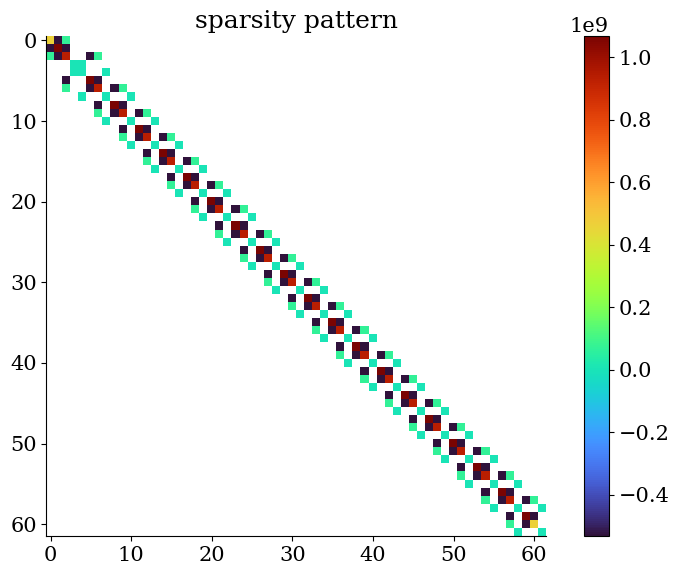

In [408]:
K, f = global_assembler(elements_u,elements_p,solution,solution*1.1,0.5)
plt.imshow(K, cmap='turbo',alpha=np.where(K==0,0.,1.))
plt.colorbar()
plt.title('sparsity pattern')
plt.tight_layout()

In [409]:
n_ids_u = np.unique([item for sublist in generate_node_ids_u(len(elements_u)) for item in sublist])
n_ids_p = np.unique([item for sublist in generate_node_ids_p(len(elements_u)) for item in sublist])

In [410]:
K_uu = K[n_ids_u[:,None],n_ids_u]
K_up = K[n_ids_u[:,None],n_ids_p]
K_pu = K[n_ids_p[:,None],n_ids_u]
K_pp = K[n_ids_p[:,None],n_ids_p]

In [411]:
print(K_uu.shape, K_pp.shape, K_up.shape, K_pu.shape)
print(K - np.block([[K_uu,K_up],[K_pu,K_pp]]))

(41, 41) (21, 21) (41, 21) (21, 41)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.06666667e+09
  -5.33333333e+08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -5.33333333e+08
   4.66666667e+08 -9.98333333e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -9.98333333e-09  0.00000000e+00]]


In [412]:
K_uu_inv = sp.linalg.inv(K_uu)
Schur = K_pp - K_pu@K_uu_inv@K_up
Schur_inv = sp.linalg.inv(Schur)
K_inv = np.block([[K_uu_inv + K_uu_inv@K_up@Schur_inv@K_pu@K_uu_inv, -K_uu_inv@K_up@Schur_inv],
                  [-Schur_inv@K_pu@K_uu_inv, Schur_inv]])
print(K_inv)

[[ 3.64722087e+05  3.64722087e+05  3.64722087e+05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.64722087e+05  3.64722087e+05  3.64722087e+05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.64722087e+05  3.64722087e+05  3.64722087e+05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -8.73502878e+08
  -8.60593898e+08 -8.56305224e+08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -8.60593898e+08
  -9.46562329e+08 -9.41845241e+08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -8.56305224e+08
  -9.41845241e+08 -1.03681943e+09]]


In [413]:
print(sp.linalg.inv(K))

[[ 3.49525333e+05  3.49525333e+05  3.49525333e+05 ...  3.49525333e+05
   3.49525333e+05  0.00000000e+00]
 [ 3.49525333e+05  3.49525333e+05  3.49525333e+05 ...  3.49525333e+05
   3.49525333e+05  0.00000000e+00]
 [ 3.49525333e+05  3.49525333e+05  3.49525333e+05 ...  3.49525333e+05
   3.49525333e+05  0.00000000e+00]
 ...
 [ 3.49525333e+05  3.49525333e+05  3.49525333e+05 ...  3.49525333e+05
   3.49525333e+05  0.00000000e+00]
 [ 3.49525333e+05  3.49525333e+05  3.49525333e+05 ...  3.49525333e+05
   3.49525333e+05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -1.03681943e+09]]


In [414]:
print(np.linalg.cond(K))
Kp,fp = precondition(K,f,'diag')
print(np.linalg.cond(Kp))

8.867610193567768e+18
2.662135958089681e+16


## Application of boundary conditions

Now we apply the natural (Neumann, nodal force) and the essential (Dirichlet, nodal displacement) boundary conditions.

In [415]:
def apply_Neumann_bc(b_glob,node_id,value):
    b_glob[node_id] += value
    return b_glob

A Dirichlet boundary condition is introduced via

$b_0 \leftarrow K_{0,0}(u_0 - \bar{u})$ so that $\Delta u_0 = \bar{u} - u_0$ and matrix condition number is not changed.

$b_{i \neq 0} \leftarrow b_{i\neq 0} - K_{i,0} (u_0 - \bar{u})$

$K_{0,i\neq 0} = K_{i\neq 0,0} \leftarrow 0$ 

This preserves $K_{ij} = K_{ji}$

In [416]:
#adapted to incremental scheme
def apply_Dirichlet_bc(K_glob,b_glob,solution,node_id,value):
    c = K_glob[node_id,node_id]
    target = solution[node_id] - value
    
    for i in range(len(b_glob)):
        b_glob[i] -= K_glob[i,node_id] * target
        b_glob[node_id] = c*target #no increment
    K_glob[node_id,:] = 0.
    K_glob[:,node_id] = 0.
    
    if (c != 0):
        K_glob[node_id,node_id] = c
    else: 
        K_glob[node_id,node_id] = 1.
        c = 1.

    #solution[node_id] = value
    return K_glob, b_glob

In [417]:
def converged(inc_u,inc_p):
    n_u = np.linalg.norm(inc_u)/len(inc_u)
    n_p = np.linalg.norm(inc_p)/len(inc_p)
    #print(n_u, n_p)
    if (n_u <= 1e-6 and n_p <=1e0):
        return True
    else:
        return False

In [418]:
def precondition(A,b,option):
    if option == 'diag':
        D_inv = np.diag(1 / np.diag(A))
        A_pre = D_inv @ A
        b_pre = D_inv @ b
        return A_pre, b_pre

In [425]:
def time_loop(elements_u,elements_p,solution,dt,t_end,p_top):
    #Startwerte
    max_iter = 50
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(len(elements_u)) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(len(elements_u)) for item in sublist])
    #
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        print("Solving time step %i." %(len(times)))
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = np.copy(y[-1]) #Starting value for recursive update
        i = 0
        #
        #print("Solution ", y_old)
        K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
        #print("Residual ", f)
        f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) # apply top load
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
        #K, f = precondition(K,f,'diag')
        #inc = sp.linalg.solve(K,-f)
        #inc = sp.sparse.linalg.bicgstab(K, -f)[0]
        lu, piv = sp.linalg.lu_factor(K)
        inc = sp.linalg.lu_solve((lu, piv), -f)
        #print("Increment ", inc)
        y_old += inc
        #print("Solution ", y_old)
        while i < max_iter and not converged(inc[n_ids_u],inc[n_ids_p]):
            K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
            #print("Residual ",f)
            f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) #apply top load
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
            #print(err)
            #K, f = precondition(K,f,'diag')
            #inc = sp.linalg.solve(K,-f)
            #inc = sp.sparse.linalg.bicgstab(K, -f)[0]
            lu, piv = sp.linalg.lu_factor(K)
            inc = sp.linalg.lu_solve((lu, piv), -f)
            #print("Increment ", inc)
            y_old += inc
            #print("Solution ", y_old)
            i +=1

        print("Performed %i iterations." %i)
        #print(solution)
        y.append(y_old) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

In [426]:
def time_loop_Schur(elements_u,elements_p,solution,dt,t_end,p_top):
    #Startwerte
    max_iter = 50
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(len(elements_u)) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(len(elements_u)) for item in sublist])
    #
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        print("Solving time step %i." %(len(times)))
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = np.copy(y[-1]) #Starting value for recursive update
        i = 0
        #
        #print("Solution ", y_old)
        K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
        #print("Residual ", f)
        f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) # apply top load
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
        
        K_uu = K[n_ids_u[:,None],n_ids_u]
        K_up = K[n_ids_u[:,None],n_ids_p]
        K_pu = K[n_ids_p[:,None],n_ids_u]
        K_pp = K[n_ids_p[:,None],n_ids_p]
        
        f_S = np.block([f[n_ids_u],f[n_ids_p]])
        
        K_uu_inv = sp.linalg.inv(K_uu)
        Schur = K_pp - K_pu@K_uu_inv@K_up
        Schur_inv = sp.linalg.inv(Schur)
        
        K_inv = np.block([[K_uu_inv + K_uu_inv@K_up@Schur_inv@K_pu@K_uu_inv, -K_uu_inv@K_up@Schur_inv],
                          [-Schur_inv@K_pu@K_uu_inv, Schur_inv]])
        
        #print(np.linalg.cond(K_inv))
        
        inc_S = K_inv@(-f_S)
        inc = inc_S*0.
        inc[n_ids_u] = inc_S[0:len(n_ids_u)]
        inc[n_ids_p] = inc_S[len(n_ids_u):]
        #print("Increment ", inc)
        y_old += inc
        #print("Solution ", y_old)
        while i < max_iter and not converged(inc[n_ids_u],inc[n_ids_p]):
            K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
            #print("Residual ",f)
            f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) #apply top load
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
            #print(err)
            K_uu = K[n_ids_u[:,None],n_ids_u]
            K_up = K[n_ids_u[:,None],n_ids_p]
            K_pu = K[n_ids_p[:,None],n_ids_u]
            K_pp = K[n_ids_p[:,None],n_ids_p]
            
            f_S = np.block([f[n_ids_u],f[n_ids_p]])

            K_uu_inv = sp.linalg.inv(K_uu)
            Schur = K_pp - K_pu@K_uu_inv@K_up
            Schur_inv = sp.linalg.inv(Schur)

            K_inv = np.block([[K_uu_inv + K_uu_inv@K_up@Schur_inv@K_pu@K_uu_inv, -K_uu_inv@K_up@Schur_inv],
                              [-Schur_inv@K_pu@K_uu_inv, Schur_inv]])

            inc_S = K_inv@(-f_S)
            inc = inc_S*0.
            inc[n_ids_u] = inc_S[0:len(n_ids_u)]
            inc[n_ids_p] = inc_S[len(n_ids_u):]
            #print("Increment ", inc)
            y_old += inc
            #print("Solution ", y_old)
            i +=1

        print("Performed %i iterations." %i)
        #print(solution)
        y.append(y_old) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

## Consolidation under self weight

In [427]:
number_of_elements = 20
L = 10.
nodes_per_element = 3

nodes_u,elements_u,solution_u=generate_mesh(L,number_of_elements,nodes_per_element)
nodes_p,elements_p,solution_p=generate_mesh(L,number_of_elements,nodes_per_element-1)
solution = np.append(solution_u,solution_p)

In [432]:
def Stiffness(z):
    return 1e8

def gamma_r(z):
    n=0.4
    return -(26000.*(1.-n) + 10000.*n) #kg/m³

def gamma_w():
    return -10000.

def Conductivity(z):
    return 1e-14/1e-3

def Compressibility(z):
    return 5e-10*0.4

In [433]:
day_in_sec = 86400

In [434]:
p_top = lambda t: 1e5
times, sols = time_loop(elements_u,elements_p,solution,day_in_sec,10*day_in_sec,p_top)

Solving time step 1.
Performed 27 iterations.
Solving time step 2.
Performed 15 iterations.
Solving time step 3.
Performed 13 iterations.
Solving time step 4.
Performed 9 iterations.
Solving time step 5.
Performed 7 iterations.
Solving time step 6.
Performed 3 iterations.
Solving time step 7.
Performed 1 iterations.
Solving time step 8.
Performed 0 iterations.
Solving time step 9.
Performed 0 iterations.
Solving time step 10.
Performed 0 iterations.


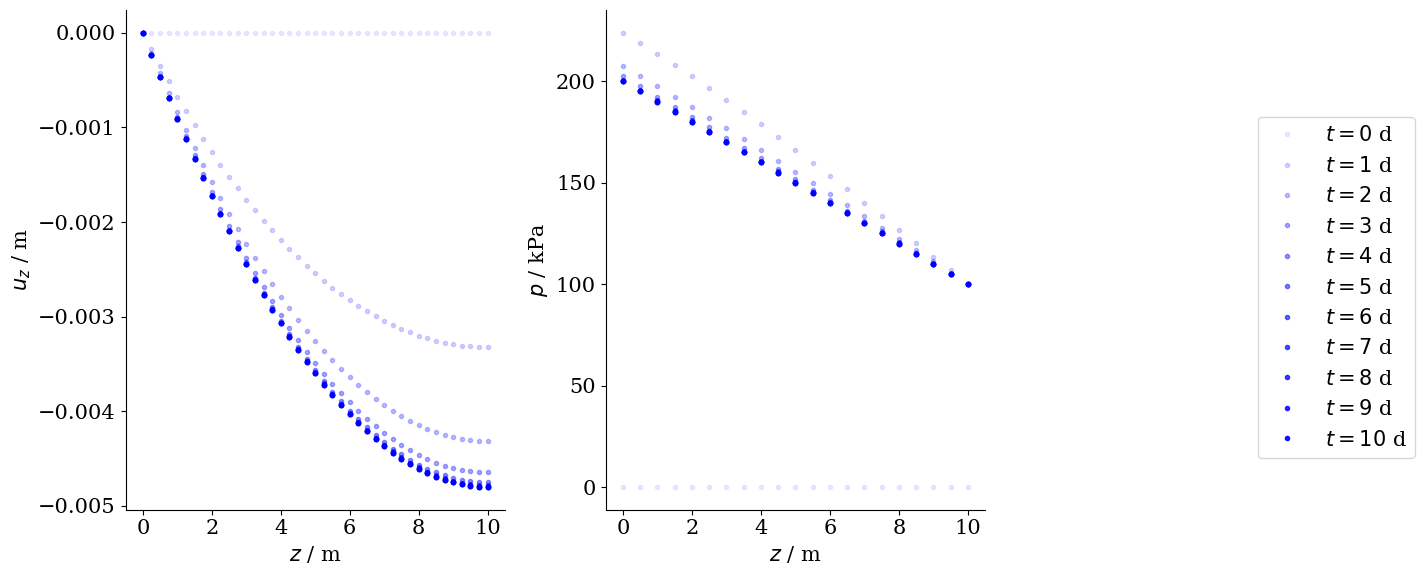

In [435]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
for i, t in enumerate(times):
    sol_u, sol_p = split_sol(len(elements_u), sols[i])
    ax[0].plot(nodes_u, sol_u, label='$t = %i$ d' % (t/day_in_sec), color='blue', alpha=(i+1)/(len(times)+1), ls='', marker='.')
    ax[1].plot(nodes_p, sol_p/1e3, color='blue', alpha=(i+1)/(len(times)+1), ls='', marker='.')

ax[0].set_xlabel('$z$ / m')
ax[1].set_xlabel('$z$ / m')
ax[0].set_ylabel('$u_z$ / m')
ax[1].set_ylabel('$p$ / kPa')
# Add the legend next to the plots
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the legend

## Testing restart / IC

Starting the same simulation but with final result.

In [365]:
times, sols = time_loop_Schur(elements_u,elements_p,sols[-1],day_in_sec,4*day_in_sec,p_top)

Solving time step 1.
Performed 2 iterations.
Solving time step 2.
Performed 0 iterations.
Solving time step 3.
Performed 0 iterations.
Solving time step 4.
Performed 0 iterations.


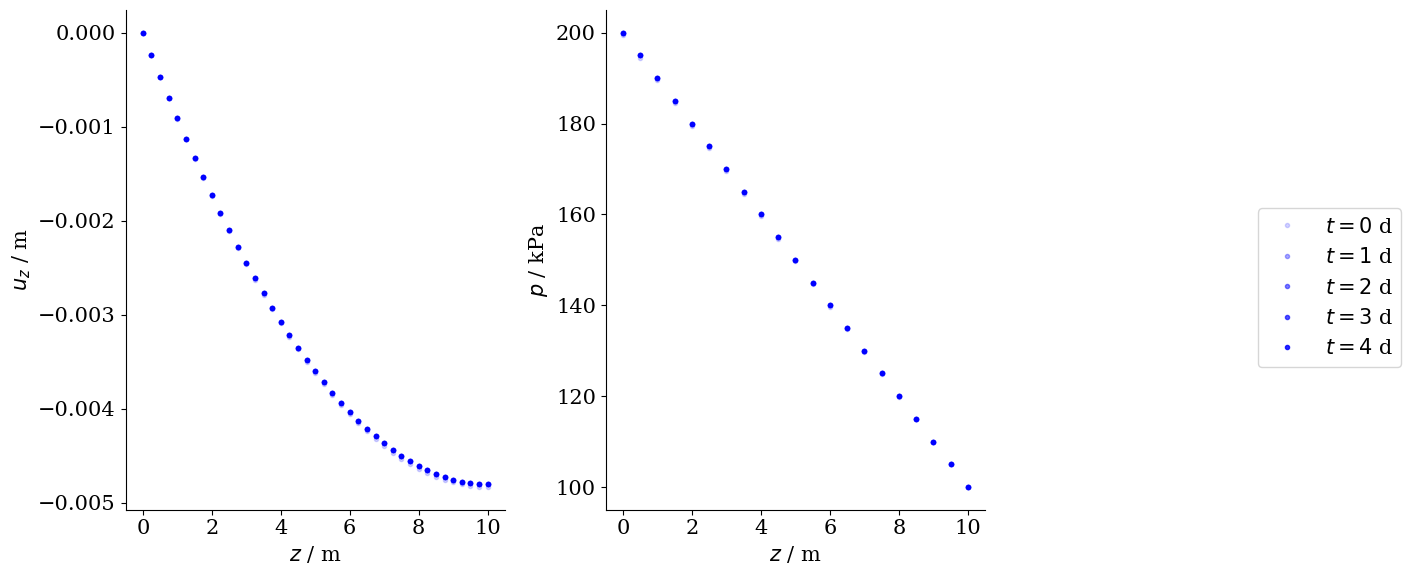

In [366]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
for i, t in enumerate(times):
    sol_u, sol_p = split_sol(len(elements_u), sols[i])
    ax[0].plot(nodes_u, sol_u, label='$t = %i$ d' % (t/day_in_sec), color='blue', alpha=(i+1)/(len(times)+1), ls='', marker='.')
    ax[1].plot(nodes_p, sol_p/1e3, color='blue', alpha=(i+1)/(len(times)+1), ls='', marker='.')

ax[0].set_xlabel('$z$ / m')
ax[1].set_xlabel('$z$ / m')
ax[0].set_ylabel('$u_z$ / m')
ax[1].set_ylabel('$p$ / kPa')
# Add the legend next to the plots
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the legend

## Consolidation

As in Terzaghi scripts.

In [337]:
number_of_elements = 40
L = 10.
nodes_per_element = 3

nodes_u,elements_u,solution_u=generate_mesh(L,number_of_elements,nodes_per_element)
nodes_p,elements_p,solution_p=generate_mesh(L,number_of_elements,nodes_per_element-1)
solution = np.append(solution_u,solution_p)

In [367]:
def time_loop(elements_u,elements_p,solution,dt,t_end,p_top):
    #Startwerte
    max_iter = 20
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(len(elements_u)) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(len(elements_u)) for item in sublist])
    #
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        print("Solving time step %i." %(len(times)))
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = np.copy(y[-1]) #Starting value for recursive update
        i = 0
        #
        #print("Solution ", y_old)
        K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
        #print("Residual ", f)
        f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) # apply top load
        #f = apply_Neumann_bc(f,n_ids_p[0],1e-14*dt) #apply top load
        #K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[-1], -1e-2)
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
        #for k in range(len(n_ids_u)):
        #    K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[k], nodes_u[k]/100) #Fix p at top
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], 0.) #Fix p at top
        #inc = sp.linalg.solve(K,-f)
        inc = sp.sparse.linalg.bicgstab(K, -f)[0]
        #print("Increment ", inc)
        y_old += inc
        #print("Solution ", y_old)
        while i < max_iter and not converged(inc[n_ids_u],inc[n_ids_p]):
            K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
            #print("Residual ",f)
            f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) #apply top load
            #f = apply_Neumann_bc(f,n_ids_p[0],1e-14*dt) #apply top load
            #K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[-1], -1e-2)
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
            #for k in range(len(n_ids_u)):
            #    K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[k], nodes_u[k]/100) #Fix p at top
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], 0.) #Fix p at top
            #print(err)
            #inc = sp.linalg.solve(K,-f)
            inc = sp.sparse.linalg.bicgstab(K, -f)[0]
            #print("Increment ", inc)
            y_old += inc
            #print("Solution ", y_old)
            i +=1

        print("Performed %i iterations." %i)
        #print(solution)
        y.append(y_old) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

In [368]:
def time_loop_Schur(elements_u,elements_p,solution,dt,t_end,p_top):
    #Startwerte
    max_iter = 50
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(len(elements_u)) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(len(elements_u)) for item in sublist])
    #
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        print("Solving time step %i." %(len(times)))
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = np.copy(y[-1]) #Starting value for recursive update
        i = 0
        #
        #print("Solution ", y_old)
        K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
        f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) # apply top load
        #f = apply_Neumann_bc(f,n_ids_p[0],1e-14*dt) #apply top load
        #K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[-1], -1e-2)
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
        #for k in range(len(n_ids_u)):
        #    K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[k], nodes_u[k]/100) #Fix p at top
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], 0.) #Fix p at top
        
        K_uu = K[n_ids_u[:,None],n_ids_u]
        K_up = K[n_ids_u[:,None],n_ids_p]
        K_pu = K[n_ids_p[:,None],n_ids_u]
        K_pp = K[n_ids_p[:,None],n_ids_p]
        
        f_S = np.block([f[n_ids_u],f[n_ids_p]])
        
        K_uu_inv = sp.linalg.inv(K_uu)
        Schur = K_pp - K_pu@K_uu_inv@K_up
        Schur_inv = sp.linalg.inv(Schur)
        
        K_inv = np.block([[K_uu_inv + K_uu_inv@K_up@Schur_inv@K_pu@K_uu_inv, -K_uu_inv@K_up@Schur_inv],
                          [-Schur_inv@K_pu@K_uu_inv, Schur_inv]])
        
        inc_S = K_inv@(-f_S)
        inc = inc_S*0.
        inc[n_ids_u] = inc_S[0:len(n_ids_u)]
        inc[n_ids_p] = inc_S[len(n_ids_u):]
        #print("Increment ", inc)
        y_old += inc
        #print("Solution ", y_old)
        while i < max_iter and not converged(inc[n_ids_u],inc[n_ids_p]):
            K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
            f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) #apply top load
            #f = apply_Neumann_bc(f,n_ids_p[0],1e-14*dt) #apply top load
            #K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[-1], -1e-2)
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
            #for k in range(len(n_ids_u)):
            #    K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[k], nodes_u[k]/100) #Fix p at top
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], 0.) #Fix p at top
            #print(err)
            K_uu = K[n_ids_u[:,None],n_ids_u]
            K_up = K[n_ids_u[:,None],n_ids_p]
            K_pu = K[n_ids_p[:,None],n_ids_u]
            K_pp = K[n_ids_p[:,None],n_ids_p]
            
            f_S = np.block([f[n_ids_u],f[n_ids_p]])

            K_uu_inv = sp.linalg.inv(K_uu)
            Schur = K_pp - K_pu@K_uu_inv@K_up
            Schur_inv = sp.linalg.inv(Schur)

            K_inv = np.block([[K_uu_inv + K_uu_inv@K_up@Schur_inv@K_pu@K_uu_inv, -K_uu_inv@K_up@Schur_inv],
                              [-Schur_inv@K_pu@K_uu_inv, Schur_inv]])

            inc_S = K_inv@(-f_S)
            inc = inc_S*0.
            inc[n_ids_u] = inc_S[0:len(n_ids_u)]
            inc[n_ids_p] = inc_S[len(n_ids_u):]
            #print("Increment ", inc)
            y_old += inc
            #print("Solution ", y_old)
            i +=1

        print("Performed %i iterations." %i)
        #print(solution)
        y.append(y_old) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

In [369]:
def Stiffness(z):
    return 5e6

def gamma_r(z):
    return 0

def gamma_w():
    return 0

def Conductivity(z):
    return 1e-5 / 1e4 # k/mu = k_f/gamma_w

def Compressibility(z):
    return 5e-10*0.4

In [370]:
day_in_sec = 86400
p_top = lambda t: 2e5
times, sols = time_loop(elements_u,elements_p,solution,day_in_sec/2,day_in_sec*20,p_top)

Solving time step 1.
Performed 20 iterations.
Solving time step 2.
Performed 20 iterations.
Solving time step 3.
Performed 20 iterations.
Solving time step 4.
Performed 20 iterations.
Solving time step 5.
Performed 20 iterations.
Solving time step 6.
Performed 20 iterations.
Solving time step 7.
Performed 20 iterations.
Solving time step 8.
Performed 20 iterations.
Solving time step 9.
Performed 20 iterations.
Solving time step 10.
Performed 20 iterations.
Solving time step 11.
Performed 20 iterations.
Solving time step 12.
Performed 20 iterations.
Solving time step 13.
Performed 20 iterations.
Solving time step 14.
Performed 20 iterations.
Solving time step 15.
Performed 20 iterations.
Solving time step 16.
Performed 11 iterations.
Solving time step 17.
Performed 1 iterations.
Solving time step 18.
Performed 1 iterations.
Solving time step 19.
Performed 1 iterations.
Solving time step 20.
Performed 1 iterations.
Solving time step 21.
Performed 1 iterations.
Solving time step 22.
Perfo

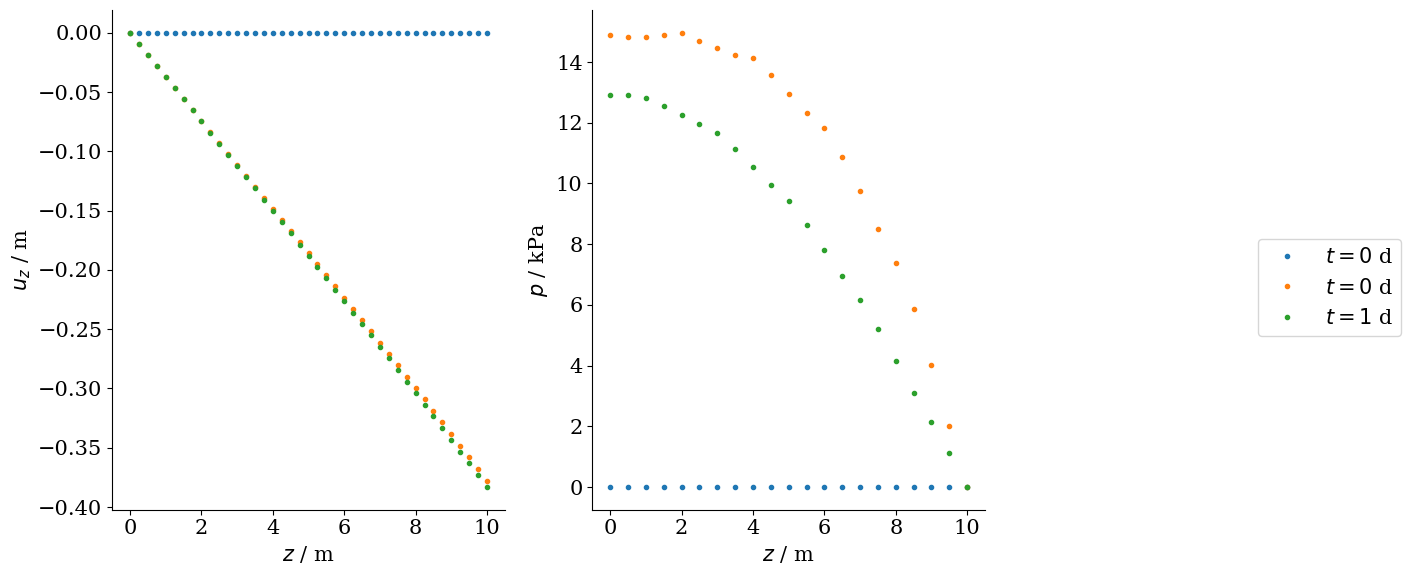

In [371]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ttimes = [0,1,2]#,30]#,200,-1]
for i in ttimes:
    t = times[i]
    sol_u, sol_p = split_sol(len(elements_u), sols[i])
    ax[0].plot(nodes_u, sol_u, label='$t = %i$ d' % (t/day_in_sec), ls='', marker='.')
    ax[1].plot(nodes_p, sol_p/1e3, ls='', marker='.')

ax[0].set_xlabel('$z$ / m')
ax[1].set_xlabel('$z$ / m')
ax[0].set_ylabel('$u_z$ / m')
ax[1].set_ylabel('$p$ / kPa')
# Add the legend next to the plots
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the legend

## Pressure drawdown

In [372]:
number_of_elements = 20
L = 10.
nodes_per_element = 3

nodes_u,elements_u,solution_u=generate_mesh(L,number_of_elements,nodes_per_element)
nodes_p,elements_p,solution_p=generate_mesh(L,number_of_elements,nodes_per_element-1)
solution = np.append(solution_u,solution_p)

In [373]:
def time_loop(elements_u,elements_p,solution,dt,t_end,p_top,debug=False):
    #Startwerte
    max_iter = 50
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(len(elements_u)) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(len(elements_u)) for item in sublist])
    #
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        print("Solving time step %i." %(len(times)))
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = np.copy(y[-1]) #Starting value for recursive update
        i = 0
        #
        #print("Solution ", y_old)
        K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
        #print("Residual ", f)
        f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) # apply top load
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
        #inc = sp.linalg.solve(K,-f)
        inc = sp.sparse.linalg.bicgstab(K, -f)[0]
        #print("Increment ", inc)
        y_old += inc
        #print("Solution ", y_old)
        while i < max_iter and not converged(inc[n_ids_u],inc[n_ids_p]):
            K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
            #print("Residual ",f)
            f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) #apply top load
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
            #print(err)
            #inc = sp.linalg.solve(K,-f)
            inc = sp.sparse.linalg.bicgstab(K, -f)[0]
            #print("Increment ", inc)
            y_old += inc
            #print("Solution ", y_old)
            i +=1

        print("Performed %i iterations." %i)
        #print(solution)
        y.append(y_old) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

In [374]:
def time_loop_Schur(elements_u,elements_p,solution,dt,t_end,p_top):
    #Startwerte
    max_iter = 50
    y = [solution] #create a list that will hold the solution vectors at all time points
    times = np.array([0.])
    n_ids_u = np.unique([item for sublist in generate_node_ids_u(len(elements_u)) for item in sublist])
    n_ids_p = np.unique([item for sublist in generate_node_ids_p(len(elements_u)) for item in sublist])
    #
    while times[-1]+dt < t_end + dt/2: #repeat the loop as long as the final time step is below the end point
        print("Solving time step %i." %(len(times)))
        times = np.append(times,times[-1]+dt) #here define the next time point as the previous time point plus the time increment dt
        y_old = np.copy(y[-1]) #Starting value for recursive update
        i = 0
        #
        #print("Solution ", y_old)
        K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
        #print("Residual ", f)
        f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) # apply top load
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
        K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
        
        K_uu = K[n_ids_u[:,None],n_ids_u]
        K_up = K[n_ids_u[:,None],n_ids_p]
        K_pu = K[n_ids_p[:,None],n_ids_u]
        K_pp = K[n_ids_p[:,None],n_ids_p]
        
        f_S = np.block([f[n_ids_u],f[n_ids_p]])
        
        K_uu_inv = sp.linalg.inv(K_uu)
        Schur = K_pp - K_pu@K_uu_inv@K_up
        Schur_inv = sp.linalg.inv(Schur)
        
        K_inv = np.block([[K_uu_inv + K_uu_inv@K_up@Schur_inv@K_pu@K_uu_inv, -K_uu_inv@K_up@Schur_inv],
                          [-Schur_inv@K_pu@K_uu_inv, Schur_inv]])
        
        inc_S = K_inv@(-f_S)
        inc = inc_S*0.
        inc[n_ids_u] = inc_S[0:len(n_ids_u)]
        inc[n_ids_p] = inc_S[len(n_ids_u):]
        #print("Increment ", inc)
        y_old += inc
        #print("Solution ", y_old)
        while i < max_iter and not converged(inc[n_ids_u],inc[n_ids_p]):
            K, f = global_assembler(elements_u,elements_p,y_old,y[-1],dt)
            #print("Residual ",f)
            f = apply_Neumann_bc(f,n_ids_u[-1],p_top(times[-1])) #apply top load
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_u[0], 0.) #Fix u at bottom
            K, f = apply_Dirichlet_bc(K, f, y_old, n_ids_p[-1], p_top(times[-1])) #Fix p at top
            #print(err)
            K_uu = K[n_ids_u[:,None],n_ids_u]
            K_up = K[n_ids_u[:,None],n_ids_p]
            K_pu = K[n_ids_p[:,None],n_ids_u]
            K_pp = K[n_ids_p[:,None],n_ids_p]
            
            f_S = np.block([f[n_ids_u],f[n_ids_p]])

            K_uu_inv = sp.linalg.inv(K_uu)
            Schur = K_pp - K_pu@K_uu_inv@K_up
            Schur_inv = sp.linalg.inv(Schur)

            K_inv = np.block([[K_uu_inv + K_uu_inv@K_up@Schur_inv@K_pu@K_uu_inv, -K_uu_inv@K_up@Schur_inv],
                              [-Schur_inv@K_pu@K_uu_inv, Schur_inv]])

            inc_S = K_inv@(-f_S)
            inc = inc_S*0.
            inc[n_ids_u] = inc_S[0:len(n_ids_u)]
            inc[n_ids_p] = inc_S[len(n_ids_u):]
            #print("Increment ", inc)
            y_old += inc
            #print("Solution ", y_old)
            i +=1

        print("Performed %i iterations." %i)
        #print(solution)
        y.append(y_old) #append the new found solution to the solution vector
         #store how much iterations this time step took to converge
    return times, y

In [380]:
def Stiffness(z):
    #return 1e8 * np.heaviside(z,0) + 100*np.heaviside(-z,0)
    return 1e8

def gamma_r(z):
    n=0.4
    return -(26000.*(1.-n) + 10000.*n) #kg/m³

def gamma_w():
    return -10000.

def Conductivity(z):
    #return 1e-17/1e-3 * np.heaviside(z,0) + 1e-12/1e-3*np.heaviside(-z,0)
    return 1e-14/1e-3

def Compressibility(z):
    return 5e-10*0.4

In [381]:
p_top = lambda t: 1e5
times, sols = time_loop(elements_u,elements_p,solution,day_in_sec,10*day_in_sec,p_top)

Solving time step 1.
Performed 50 iterations.
Solving time step 2.
Performed 50 iterations.
Solving time step 3.
Performed 50 iterations.
Solving time step 4.
Performed 50 iterations.
Solving time step 5.
Performed 50 iterations.
Solving time step 6.
Performed 23 iterations.
Solving time step 7.
Performed 3 iterations.
Solving time step 8.
Performed 3 iterations.
Solving time step 9.
Performed 3 iterations.
Solving time step 10.
Performed 3 iterations.


In [382]:
rate = 1e5/day_in_sec
duration = 0.5*day_in_sec
p_drawdown = lambda t: 1e5 - rate*np.minimum(t,duration)

In [383]:
times, sols_dd = time_loop(elements_u,elements_p,sols[-1],day_in_sec,4*day_in_sec,p_drawdown)

Solving time step 1.
Performed 50 iterations.
Solving time step 2.
Performed 39 iterations.
Solving time step 3.
Performed 27 iterations.
Solving time step 4.
Performed 3 iterations.


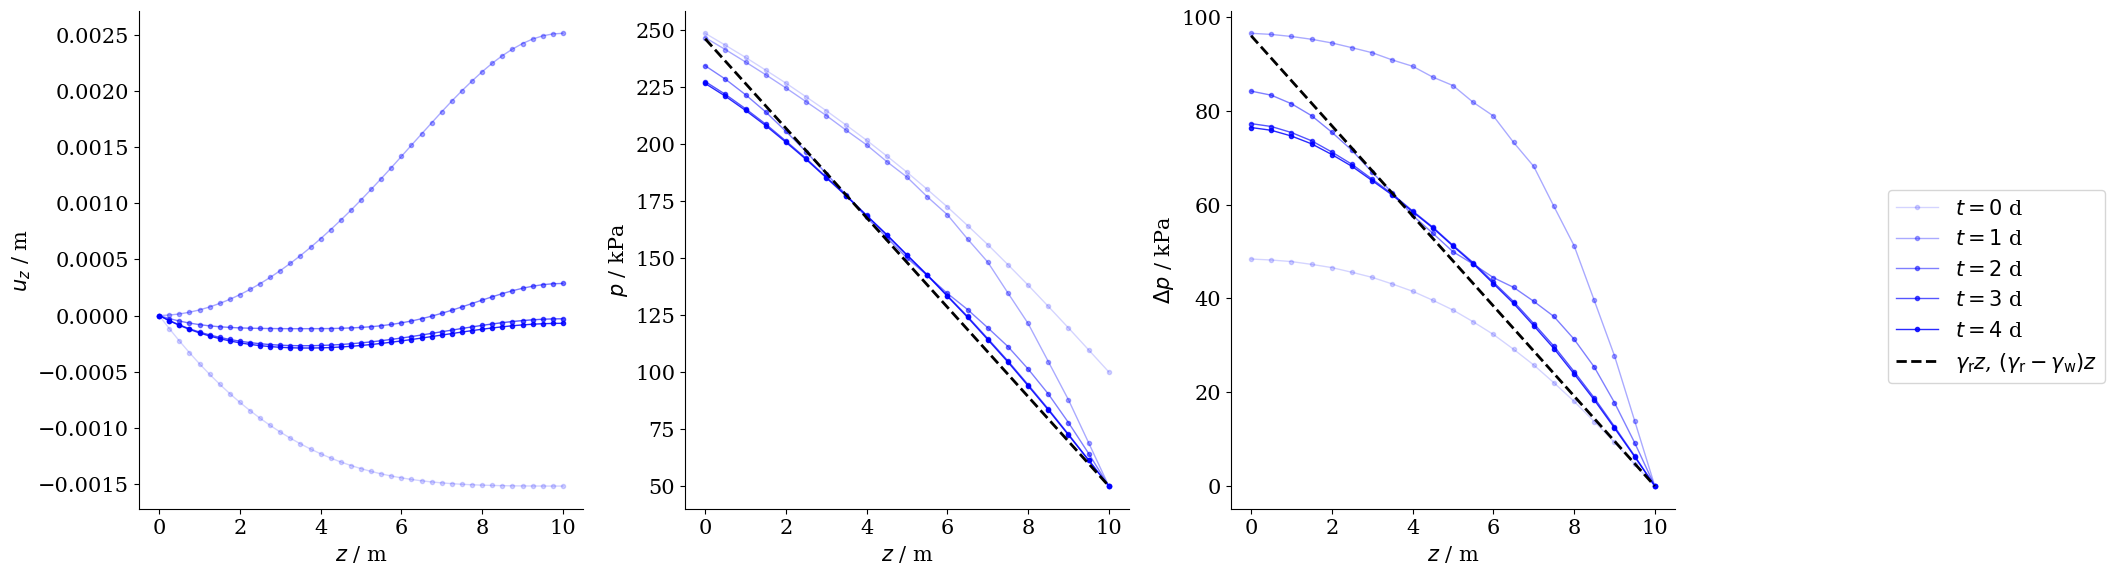

In [384]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))
for i, t in enumerate(times):
    sol_u, sol_p = split_sol(len(elements_u), sols_dd[i])
    ax[0].plot(nodes_u, sol_u, color='blue', alpha=(i+1)/(len(times)+1), marker='.',lw=1)
    ax[1].plot(nodes_p, sol_p/1e3, color='blue', alpha=(i+1)/(len(times)+1), marker='.',lw=1)
    ax[2].plot(nodes_p, sol_p/1e3- (p_drawdown(t)/1e3 - gamma_w()/1e3*(10-nodes_p)), color='blue', alpha=(i+1)/(len(times)+1), marker='.',lw=1, label='$t = %i$ d' % (t/day_in_sec))

ax[1].plot(nodes_p, p_drawdown(t)/1e3-(gamma_r(0))/1e3*(10-nodes_p),color='black',ls='--',label='$\gamma_\mathrm{r} z$')
ax[2].plot(nodes_p, -(gamma_r(0)-gamma_w())/1e3*(10-nodes_p),color='black',ls='--',label='$\gamma_\mathrm{r} z$, $(\gamma_\mathrm{r}-\gamma_\mathrm{w}) z$')

ax[0].set_xlabel('$z$ / m')
ax[1].set_xlabel('$z$ / m')
ax[2].set_xlabel('$z$ / m')
ax[0].set_ylabel('$u_z$ / m')
ax[1].set_ylabel('$p$ / kPa')
ax[2].set_ylabel('$\Delta p$ / kPa')
#ax[2].set_ylim(0,50)
# Add the legend next to the plots
handles, labels = ax[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)

fig.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the layout to make room for the legend